# OASIS lookup helper
Provides `get_oasis_record(image_name, csv_path='OASIS.csv', exact=False)` to return a row as a dict from `OASIS.csv`.

In [151]:
import pandas as pd
from pathlib import Path
from typing import Optional, Dict, Any
import numpy as np
from pathlib import Path
from math import ceil
from PIL import Image as PILImage

import matplotlib.pyplot as plt

# Utility to load the OASIS CSV once and reuse the DataFrame
def load_oasis(csv_path: str = 'OASIS.csv') -> pd.DataFrame:
    """Load `csv_path` into a pandas DataFrame (strings, no NA filtering)."""
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    df = pd.read_csv(path)
    first_col = df.columns[0]
    rename_map = {}
    rename_map[first_col] = "id"
    rename_map["Theme"] = "img"
    df = df.rename(columns=rename_map)
    if "id" in df.columns:
        df = df.set_index("id")
    return df

oasis = load_oasis()


In [152]:
oasis.head()

img Category   Source  Valence_mean  Valence_SD  Valence_N  \
id                                                                     
I1   Acorns 1   Object  Pixabay      4.686275    0.954203        102   
I2   Acorns 2   Object  Pixabay      4.519608    0.841150        102   
I3   Acorns 3   Object  Pixabay      4.754902    0.958921        102   
I4  Alcohol 1   Object  Pixabay      4.685185    1.189111        108   
I5  Alcohol 2   Object  Pixabay      4.250000    1.136686        108   

    Arousal_mean  Arousal_SD  Arousal_N  
id                                       
I1      2.346535    1.602720        101  
I2      2.227723    1.399151        101  
I3      2.306931    1.514877        101  
I4      2.865385    1.695555        104  
I5      3.000000    1.700942        104

In [153]:
oasis[["Valence_mean", "Arousal_mean"]].describe()

Valence_mean  Arousal_mean
count    900.000000    900.000000
mean       4.331249      3.668098
std        1.227583      0.837789
min        1.107843      1.693069
25%        3.485149      3.182692
50%        4.519608      3.725464
75%        5.333333      4.273190
max        6.490196      5.722772

In [154]:
oasis[["Valence_mean", "Arousal_mean"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, I1 to I900
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Valence_mean  900 non-null    float64
 1   Arousal_mean  900 non-null    float64
dtypes: float64(2)
memory usage: 21.1+ KB


In [155]:
oasis.sort_values('Valence_mean', ascending=True).head()

img Category                     Source  Valence_mean  \
id                                                                         
I496  Miserable pose 3   Person                  Wikipedia      1.107843   
I287           Dummy 1   Object  Flickr/Christopher Michel      1.157407   
I208     Dead bodies 1   Person                  Wikipedia      1.198020   
I209     Dead bodies 2   Person                  Wikipedia      1.247525   
I452       KKK rally 2   Person                  Wikipedia      1.254902   

      Valence_SD  Valence_N  Arousal_mean  Arousal_SD  Arousal_N  
id                                                                
I496    0.419968        102      5.148515    2.342589        101  
I287    0.549631        108      5.201923    2.378626        104  
I208    0.735116        101      4.514563    2.484714        103  
I209    0.698655        101      4.475728    2.371583        103  
I452    0.713189        102      4.980198    2.107037        101

In [156]:
oasis.sort_values('Arousal_mean', ascending=True).head()

img Category   Source  Valence_mean  Valence_SD  Valence_N  \
id                                                                            
I860          Wall 2   Object  Pixabay      4.029412    0.496640        102   
I859          Wall 1   Object  Pixabay      4.078431    0.591797        102   
I95         Bricks 1   Object  Pixabay      4.156863    0.714006        102   
I182  Cotton swabs 3   Object  Pixabay      4.127451    0.608058        102   
I861          Wall 3   Object  Pixabay      4.058824    0.462955        102   

      Arousal_mean  Arousal_SD  Arousal_N  
id                                         
I860      1.693069    1.238891        101  
I859      1.801980    1.233043        101  
I95       1.811881    1.222398        101  
I182      1.811881    1.246699        101  
I861      1.811881    1.301636        101

In [158]:
oasis.head()

img Category   Source  Valence_mean  Valence_SD  Valence_N  \
id                                                                     
I1   Acorns 1   Object  Pixabay      4.686275    0.954203        102   
I2   Acorns 2   Object  Pixabay      4.519608    0.841150        102   
I3   Acorns 3   Object  Pixabay      4.754902    0.958921        102   
I4  Alcohol 1   Object  Pixabay      4.685185    1.189111        108   
I5  Alcohol 2   Object  Pixabay      4.250000    1.136686        108   

    Arousal_mean  Arousal_SD  Arousal_N  
id                                       
I1      2.346535    1.602720        101  
I2      2.227723    1.399151        101  
I3      2.306931    1.514877        101  
I4      2.865385    1.695555        104  
I5      3.000000    1.700942        104

In [159]:
oasis.columns

Index(['img', 'Category', 'Source', 'Valence_mean', 'Valence_SD', 'Valence_N',
       'Arousal_mean', 'Arousal_SD', 'Arousal_N'],
      dtype='object')

In [160]:
def sample_images_by_valence_arousal(
    df: pd.DataFrame = oasis, 
    valence_group: str = "high",
    arousal_group: str = "high",
    n: int = 5,
    mode: str = "both",
    percentile_p: float = 0.33,
    random_state: int | None = None,
) -> pd.DataFrame:
    """
    Sample images by valence/arousal groups.

    Parameters
    - df: DataFrame with columns ['img', 'Valence_mean', 'Arousal_mean'].
    - valence_group / arousal_group: 'high'|'low'|'mid'|'all'.
    - n: number of unique images to return (returns all rows for each sampled image).
    - mode: 'both' (default) | 'valence' | 'arousal' — which axis to apply filtering on.
    - percentile_p: percentile fraction for low/high split (e.g. 0.33 = bottom/top third).
    - valence_thresh, arousal_thresh: when method=='thresholds', provide (low_cut, high_cut).
    - random_state: seed for reproducible sampling.

    Returns
    - DataFrame with rows for the sampled images (all rows per image).
    """
    required = {"img", "Valence_mean", "Arousal_mean"}
    if not required.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required}")

    for g in (valence_group, arousal_group):
        if g not in {"high", "low", "mid", "all"}:
            raise ValueError("group must be one of 'high','low','mid','all'")

    if mode not in {"both", "valence", "arousal"}:
        raise ValueError("mode must be 'both', 'valence' or 'arousal'")
    
    center_width = 2 * percentile_p
    
    # allow pair or single value for center_width
    if isinstance(center_width, tuple) or isinstance(center_width, list):
        v_center_w, a_center_w = float(center_width[0]), float(center_width[1])
    else:
        v_center_w = a_center_w = float(center_width)

    # compute thresholds
    v_low_q = df["Valence_mean"].quantile(percentile_p)
    v_high_q = df["Valence_mean"].quantile(1 - percentile_p)
    a_low_q = df["Arousal_mean"].quantile(percentile_p)
    a_high_q = df["Arousal_mean"].quantile(1 - percentile_p)
    
    

    def group_mask(series: pd.Series, group: str, low_q: float, high_q: float, center_w: float) -> pd.Series:
        if group == "all":
            return pd.Series(True, index=series.index)
        if group == "low":
            return series <= low_q
        if group == "high":
            return series >= high_q
        if group == "mid":
            half = max(0.0, min(0.5, center_w / 2.0))
            low = series.quantile(0.5 - half)
            high = series.quantile(0.5 + half)
            return (series >= low) & (series <= high)
        # fallback
        return (series > low_q) & (series < high_q)

    # build masks depending on mode
    if mode == "both":
        v_mask = group_mask(df["Valence_mean"], valence_group, v_low_q, v_high_q, v_center_w)
        a_mask = group_mask(df["Arousal_mean"], arousal_group, a_low_q, a_high_q, a_center_w)
        combined_mask = v_mask & a_mask
    elif mode == "valence":
        combined_mask = group_mask(df["Valence_mean"], valence_group, v_low_q, v_high_q, v_center_w)
    else:  # mode == "arousal"
        combined_mask = group_mask(df["Arousal_mean"], arousal_group, a_low_q, a_high_q, a_center_w)

    candidates = df.loc[combined_mask, "img"].unique()
    if len(candidates) == 0:
        raise ValueError("No candidate images found for the requested groups/mode/thresholds.")

    rng = np.random.RandomState(random_state)
    k = min(int(n), len(candidates))
    sampled_imgs = rng.choice(candidates, size=k, replace=False)

    return df[df["img"].isin(sampled_imgs)].reset_index(drop=True)

In [161]:
df_img=sample_images_by_valence_arousal(mode="both",n=6, percentile_p=0.1, valence_group="mid", arousal_group="mid")
df_img.head()


img Category                  Source  Valence_mean  Valence_SD  \
0      Car race 3    Scene               Wikipedia      4.396040    1.077768   
1           Cat 8   Animal  Flickr/Markus Schoepke      4.764706    1.380031   
2     Nude man 14   Person     Flickr/See-ming Lee      4.342593    1.415284   
3     Nude man 19   Person               Wikipedia      4.768519    1.180895   
4  Running away 1   Person                 Pixabay      4.578431    1.214078   

   Valence_N  Arousal_mean  Arousal_SD  Arousal_N  
0        101      3.689320    1.798851        103  
1        102      3.633663    1.508130        101  
2        108      3.701923    1.970066        104  
3        108      3.798077    1.876683        104  
4        102      3.564356    1.545418        101

In [162]:
df_img_mid=sample_images_by_valence_arousal(mode="both",n=30, percentile_p=0.1, valence_group="mid", arousal_group="mid")
va_q_04=float(oasis["Valence_mean"].quantile(0.4))
va_q_06=float(oasis["Valence_mean"].quantile(0.6))
ar_q_04=float(oasis["Arousal_mean"].quantile(0.4))
ar_q_06=float(oasis["Arousal_mean"].quantile(0.6))
print(f"mid valence between {va_q_04:.2f} and {va_q_06:.2f}")
print(f"mid arousal between {ar_q_04:.2f} and {ar_q_06:.2f}")
print(f"df_img_mid va qualifies?: {df_img_mid["Valence_mean"].min()>=va_q_04 and df_img_mid["Valence_mean"].max()<=va_q_06}")
print(f"df_img_mid ar qualifies?: {df_img_mid["Arousal_mean"].min()>=ar_q_04 and df_img_mid["Arousal_mean"].max()<=ar_q_06}")

mid valence between 4.17 and 4.81
mid arousal between 3.54 and 3.96
df_img_mid va qualifies?: True
df_img_mid ar qualifies?: True


In [163]:
def show_images(
    img_names,
    images_dir: str | Path = "images",
    ext: str = ".jpg",
    n: int | None = 16,
    max_cols: int = 4,
    figsize: tuple | None = None,
    show_metadata: bool = True,
    dpi: int = 100,
    metadata_df: pd.DataFrame | None = None,
    name_col: str = "img",
):
    """
    Display images given a list/iterable of image base names.

    Parameters
    - img_names: iterable of image base names (e.g. ['Dog 6', 'Wall 3', ...]).
                 For backward compatibility this may also be a DataFrame (in which case
                 `name_col` selects the column with names).
    - images_dir: directory containing the images (Path or str).
    - ext: file extension (including dot), e.g. '.jpg'.
    - n: number of unique images to display (None = all).
    - max_cols: maximum columns in the grid.
    - figsize: matplotlib figure size; if None it's computed from grid size.
    - show_metadata: if True and metadata_df provided, includes Valence_mean/Arousal_mean in titles.
    - dpi: figure dpi.
    - metadata_df: optional DataFrame that contains columns [name_col, 'Valence_mean', 'Arousal_mean'].
    - name_col: column name in metadata_df to match image names.

    Returns: (fig, axes) matplotlib objects.
    """
    images_dir = Path(images_dir)

    # If a DataFrame was passed, extract the name column
    if hasattr(img_names, "columns") and name_col in img_names.columns:
        names = list(pd.Series(img_names[name_col]).astype(str).unique())
    else:
        names = list(pd.Series(list(img_names)).astype(str).unique())

    if n is not None:
        names = names[:n]
    total = len(names)
    if total == 0:
        raise ValueError("No images to display")

    cols = min(max_cols, total)
    rows = ceil(total / cols)
    if figsize is None:
        figsize = (cols * 3, max(3, rows * 3))

    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)

    # normalize axes to a flat list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, ax in enumerate(axes):
        if i >= total:
            ax.axis("off")
            continue

        name = names[i]
        path = images_dir / f"{name}{ext}"
        if not path.exists():
            ax.text(0.5, 0.5, f"Missing\n{name}{ext}", ha="center", va="center", fontsize=10)
            ax.set_title(name, fontsize=9)
            ax.axis("off")
            continue

        try:
            im = PILImage.open(path).convert("RGB")
        except Exception:
            ax.text(0.5, 0.5, f"Error opening\n{name}{ext}", ha="center", va="center", fontsize=10)
            ax.set_title(name, fontsize=9)
            ax.axis("off")
            continue

        ax.imshow(im)
        title = name
        if show_metadata and metadata_df is not None:
            row = metadata_df[metadata_df[name_col].astype(str) == name]
            if not row.empty:
                r = row.iloc[0]
                parts = []
                if "Valence_mean" in r.index:
                    parts.append(f"V={r['Valence_mean']:.2f}")
                if "Arousal_mean" in r.index:
                    parts.append(f"A={r['Arousal_mean']:.2f}")
                if parts:
                    title = f"{name} ({', '.join(parts)})"
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes

(<Figure size 1200x600 with 8 Axes>,
 array([<Axes: title={'center': 'Car race 3'}>,
        <Axes: title={'center': 'Cat 8'}>,
        <Axes: title={'center': 'Nude man 14'}>,
        <Axes: title={'center': 'Nude man 19'}>,
        <Axes: title={'center': 'Running away 1'}>,
        <Axes: title={'center': 'Stingray 2'}>, <Axes: >, <Axes: >],
       dtype=object))

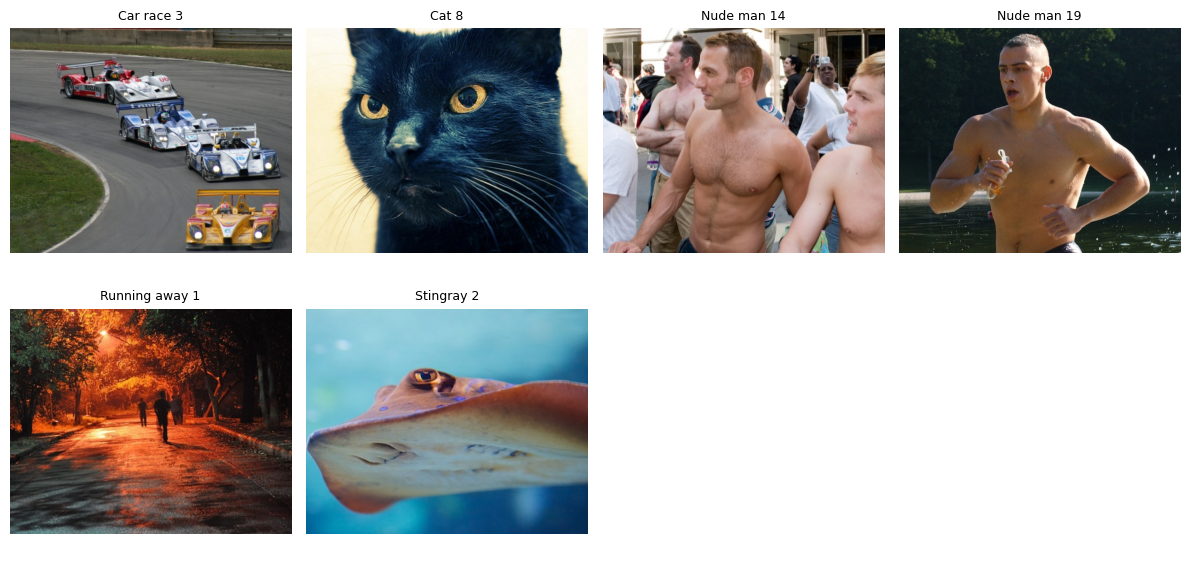

In [164]:
show_images(df_img["img"].tolist())

In [165]:
# Converted lists for categories
high_valence = ["Dog 6","Lake 9","Rainbow 2","Sunset 3",]
low_valence = ["Miserable pose 3","Tumor 1","Fire 9","Cockroach 1",]
high_arousal = ["Explosion 5","Parachuting 4","Snake 4","Lava 1",]
low_arousal = ["Wall 2","Cotton swabs 3","Office supplies 2","Socks 1",]
neutral = []

oasis_categories = {
    "high_valence": high_valence,
    "low_valence": low_valence,
    "high_arousal": high_arousal,
    "low_arousal": low_arousal,
    "neutral": neutral,
}


# Display the grouped dict
oasis_categories

{'high_valence': ['Dog 6', 'Lake 9', 'Rainbow 2', 'Sunset 3'],
 'low_valence': ['Miserable pose 3', 'Tumor 1', 'Fire 9', 'Cockroach 1'],
 'high_arousal': ['Explosion 5', 'Parachuting 4', 'Snake 4', 'Lava 1'],
 'low_arousal': ['Wall 2', 'Cotton swabs 3', 'Office supplies 2', 'Socks 1'],
 'neutral': []}

In [166]:
oasis[["Valence_mean", "Arousal_mean"]].describe()

Valence_mean  Arousal_mean
count    900.000000    900.000000
mean       4.331249      3.668098
std        1.227583      0.837789
min        1.107843      1.693069
25%        3.485149      3.182692
50%        4.519608      3.725464
75%        5.333333      4.273190
max        6.490196      5.722772

In [167]:
df_img=sample_images_by_valence_arousal(mode="valence", valence_group="high",arousal_group="high", n=6, percentile_p=0.9)
df_img.head(20)


img Category               Source  Valence_mean  Valence_SD  \
0       Dog 19   Animal              Pixabay      5.940594    0.967696   
1       Goat 1   Animal  Flickr/Neil Piddock      5.333333    1.222836   
2  Graveyard 3    Scene            Wikipedia      3.578431    1.230280   
3      Money 1   Object              Pixabay      4.960396    1.148223   
4       Snow 5    Scene              Pixabay      4.823529    0.999126   
5    Tornado 3    Scene              Pixabay      2.663366    1.227006   

   Valence_N  Arousal_mean  Arousal_SD  Arousal_N  
0        101      4.349515    1.643220        103  
1        108      3.307692    1.763034        104  
2        102      3.613861    1.593551        101  
3        101      3.679612    1.744535        103  
4        102      2.900990    1.734964        101  
5        101      4.679612    1.848230        103

In [168]:
img_per_category = 10
percentile = 0.1
banned_words = ["nude", "war"]
def image_selector(categories: Dict, img_per_category: int =10, percentile: float =0.1, banned_words: list = banned_words):
    for cat in categories.keys():
        # print(f"Category: {cat}")
        len_img = len(categories[cat])
        while len_img < img_per_category:
            diff = img_per_category - len_img
            if cat == "neutral":
                group = "mid"
                mode = "both"
            else:
                group, mode = cat.split("_")
                
            # print(f"  Sampling {diff} images for group '{group}' in mode '{mode}' with percentile {percentile}")
            df = sample_images_by_valence_arousal(mode=mode, valence_group=group, arousal_group=group, n=diff, percentile_p=percentile)
            categories[cat].extend(df["img"].tolist())

            # remove banned items starting with any banned word (case-insensitive)
            bw_lower = [bw.lower() for bw in banned_words]
            before = len(categories[cat])
            categories[cat] = [
                name for name in categories[cat]
                if not any(name.lower().startswith(bw) for bw in bw_lower)
            ]
            removed = before - len(categories[cat])
            # if removed:
            #     print(f"  Removed {removed} banned item(s)")
            
            categories[cat] = list(set(categories[cat]))
            len_img = len(categories[cat])

image_selector(oasis_categories, img_per_category, percentile, banned_words)



Category: high_valence
len: 10
Category: low_valence
len: 10
Category: high_arousal
len: 10
Category: low_arousal
len: 10
Category: neutral
len: 10


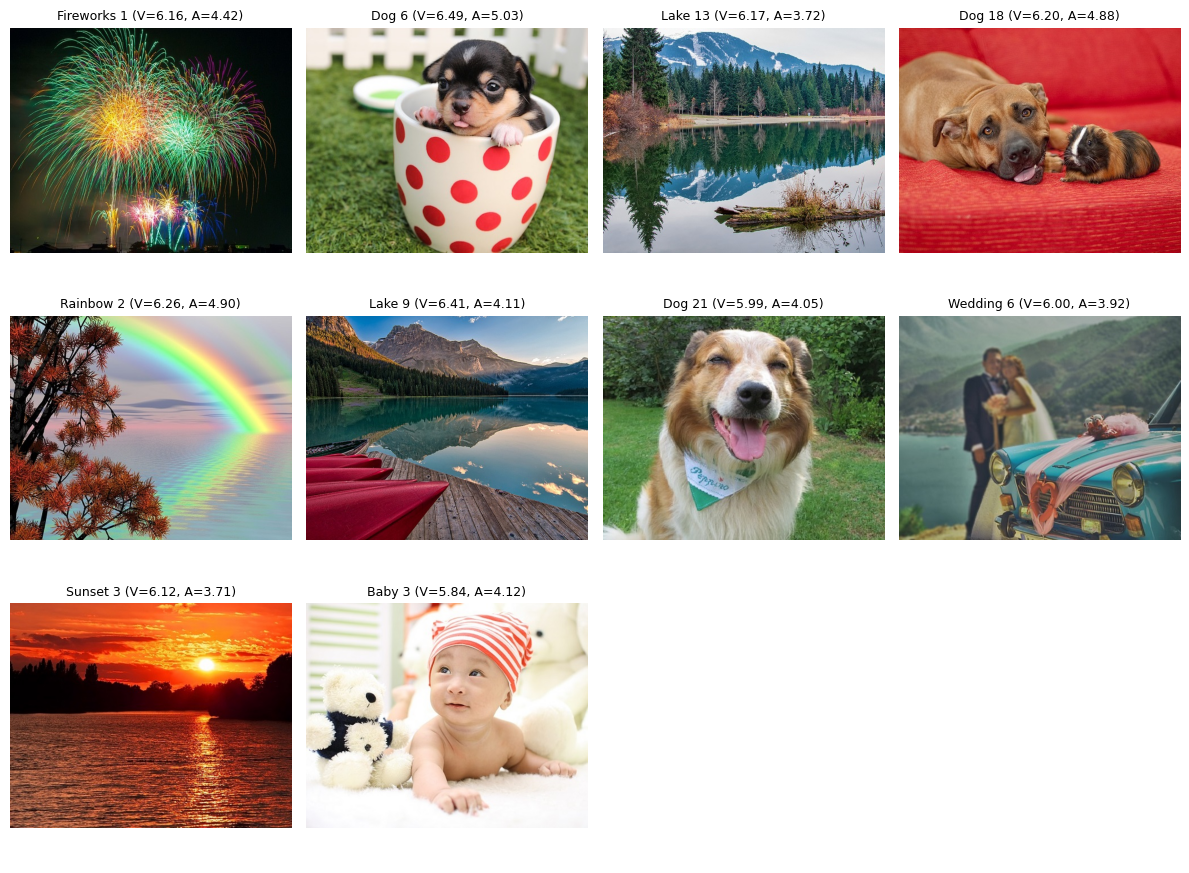

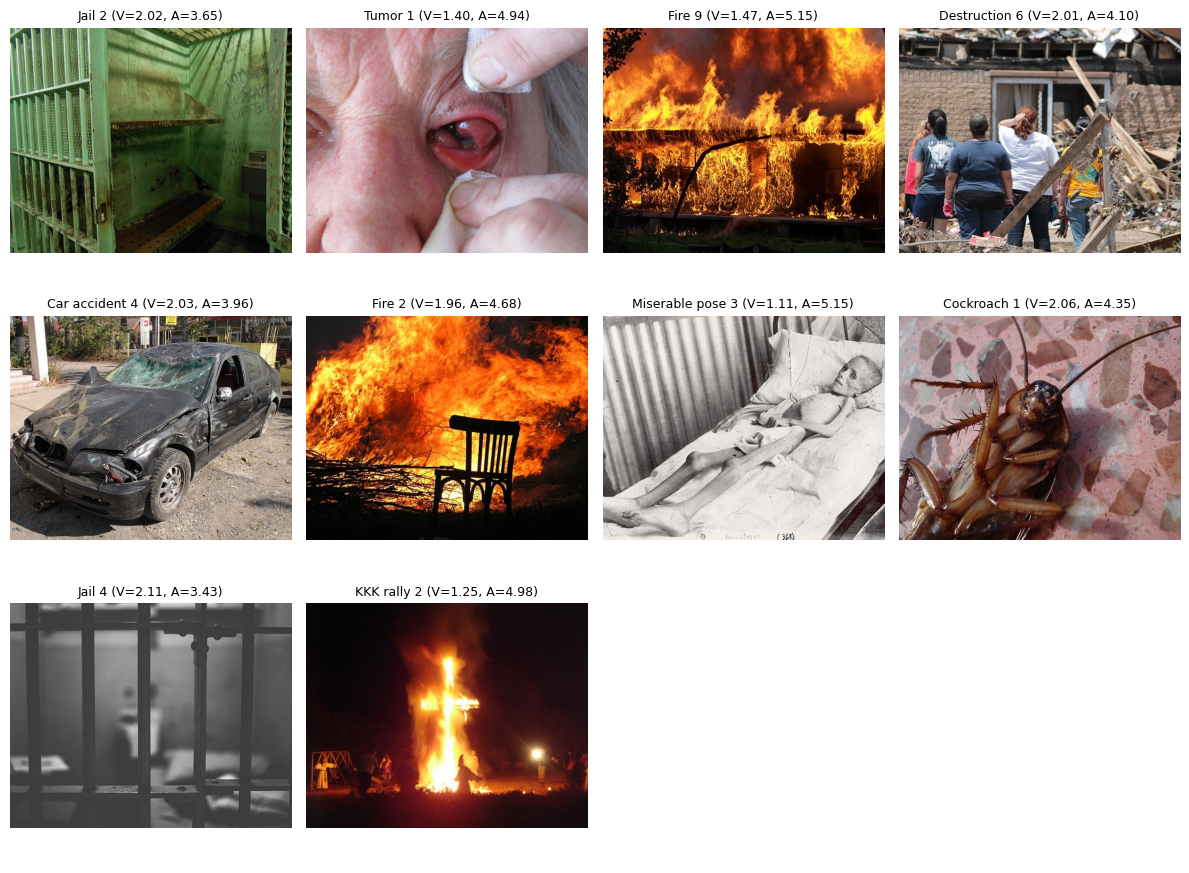

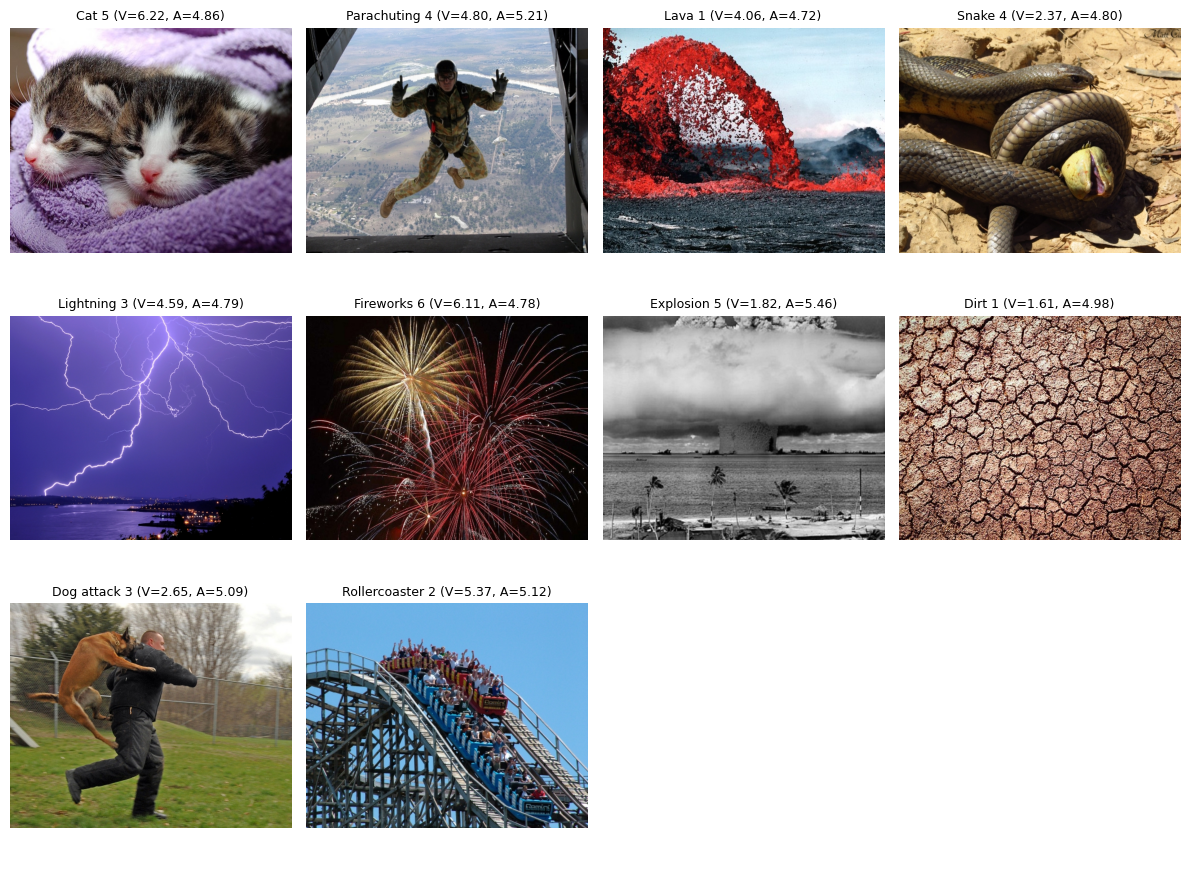

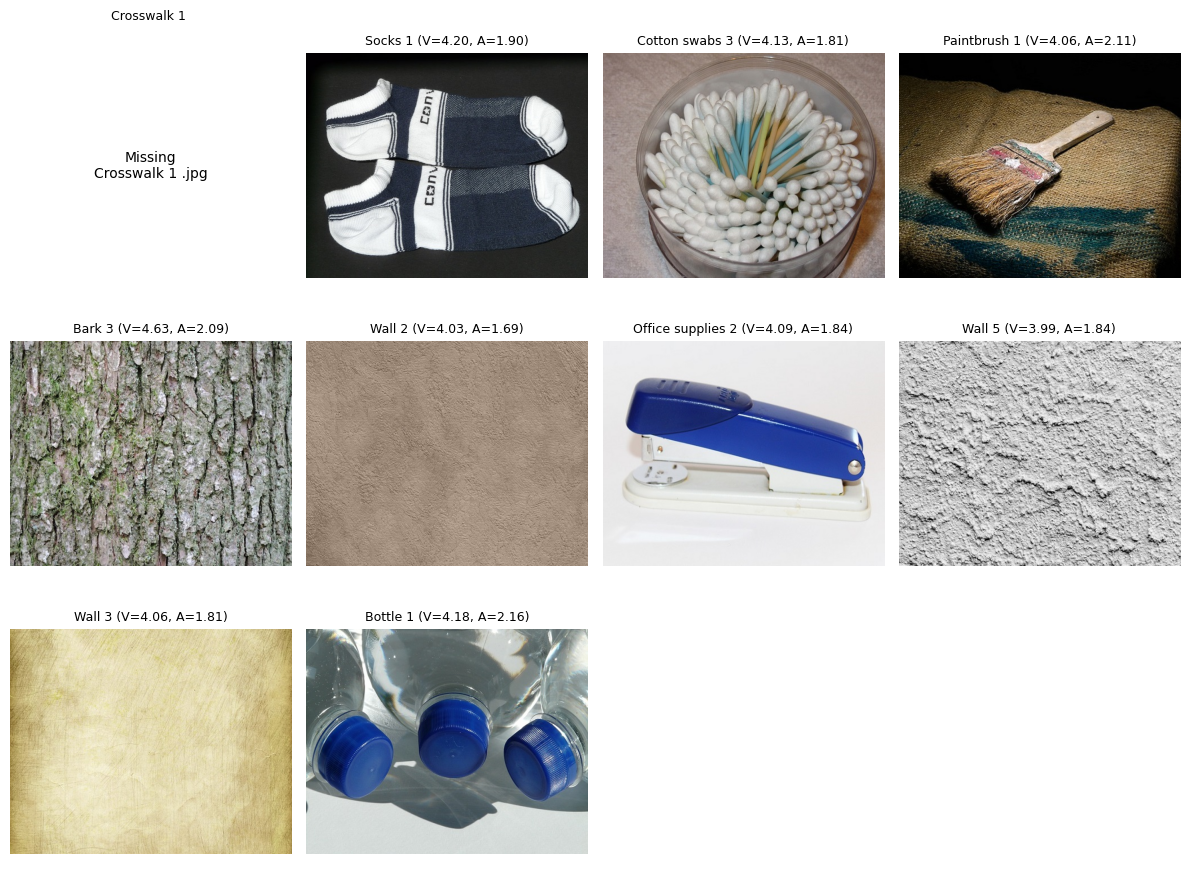

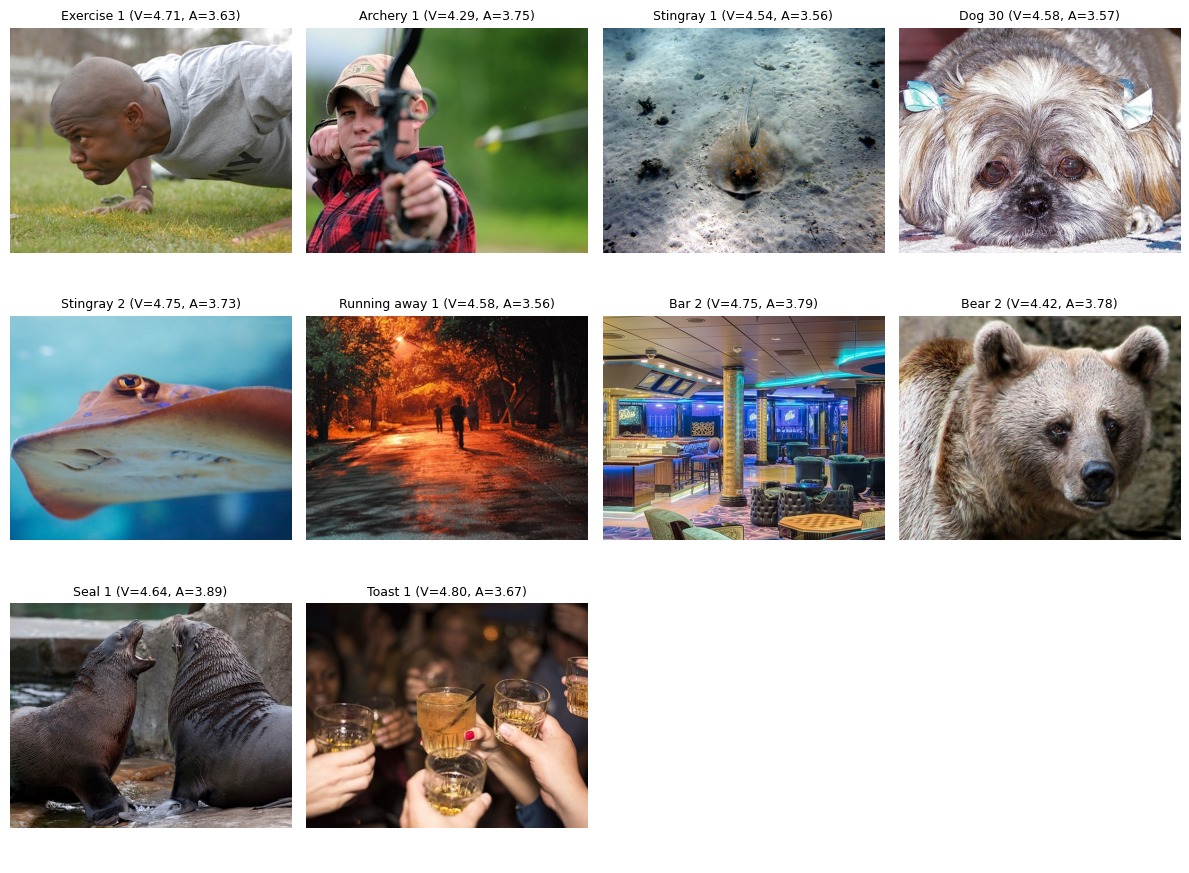

In [169]:
for cat in oasis_categories.keys():
    print(f"Category: {cat}")
    print(f"len: {len(oasis_categories[cat])}")
    show_images(oasis_categories[cat], metadata_df=oasis)

In [170]:

for cat, img_names in oasis_categories.items():
    print(f"Category: {cat}, Images: {len(img_names)}")

Category: high_valence, Images: 10
Category: low_valence, Images: 10
Category: high_arousal, Images: 10
Category: low_arousal, Images: 10
Category: neutral, Images: 10


In [171]:
len(low_arousal)


10

In [174]:
def get_oasis_record(image_names, df: pd.DataFrame = oasis) -> Dict[str, Any]:
    """Return a dict mapping each requested name to a small record dict (or None if not found).

    - `image_names` must be an iterable of names (list/tuple/Series). A single string is NOT accepted.
    - Returns: {name: {"img": ..., "Valence_mean": ..., "Arousal_mean": ...} | None}
    """
    if isinstance(image_names, str) or not hasattr(image_names, "__iter__"):
        raise TypeError("image_names must be an iterable of strings (e.g. list/tuple), not a single string")

    df_str = df.astype(str)
    names = [str(n) for n in list(image_names)]
    result: Dict[str, Any] = {}

    for name in names:
        mask = df_str["img"] == name

        matches = df.loc[mask]
        if matches.empty:
            print(f"Warning: no match found for image name '{name}'")
        else:
            m = matches.iloc[0].to_dict()
            result[name] = {
                "Valence_mean": m.get("Valence_mean"),
                "Arousal_mean": m.get("Arousal_mean"),
            }

    return result

df = get_oasis_record(['Wall 3', 'Dog 6', 'Nonexistent Image'])
df

{'Wall 3': {'Valence_mean': 4.05882352941176,
  'Arousal_mean': 1.81188118811881},
 'Dog 6': {'Valence_mean': 6.49019607843137, 'Arousal_mean': 5.02970297029703}}

In [176]:
def categorize_selected_imgs(
    image_names: list,
    df: pd.DataFrame = oasis,
    percentile_p: float = 0.33,
) -> Dict[str, Any]:
    """Categorize a list of images by valence/arousal groups.

    Parameters
    - image_names: iterable of image base names (list/tuple/Series). A single string is NOT accepted.
    - df: oasis dataframe
    - percentile_p: percentile fraction for low/high split (e.g. 0.33 = bottom/top third)

    Returns:
    - dict mapping image_name -> {img, Valence_mean, Arousal_mean, valence_group, arousal_group} or None if not found
    """
    if isinstance(image_names, str) or not hasattr(image_names, "__iter__"):
        raise TypeError("image_names must be an iterable of strings (e.g. list/tuple), not a single string")

    # get records for all requested names (get_oasis_record already warns for missing names)
    records = get_oasis_record(list(image_names), df)

    v_low_q = df["Valence_mean"].quantile(percentile_p)
    v_high_q = df["Valence_mean"].quantile(1 - percentile_p)
    a_low_q = df["Arousal_mean"].quantile(percentile_p)
    a_high_q = df["Arousal_mean"].quantile(1 - percentile_p)

    result: Dict[str, Any] = {}
    for name in image_names:
        rec = records.get(name)

        valence = float(rec["Valence_mean"])
        arousal = float(rec["Arousal_mean"])

        if valence <= v_low_q:
            valence_group = "low"
        elif valence >= v_high_q:
            valence_group = "high"
        else:
            valence_group = "mid"

        if arousal <= a_low_q:
            arousal_group = "low"
        elif arousal >= a_high_q:
            arousal_group = "high"
        else:
            arousal_group = "mid"

        result[name] = {
            "img": name,
            "Valence_mean": valence,
            "Arousal_mean": arousal,
            "valence_group": valence_group,
            "arousal_group": arousal_group,
        }

    return result

In [179]:
all_img = []
for cat_imgs in oasis_categories.values():
    all_img.extend(cat_imgs)
all_img = list(set(all_img))
# len(all_img)
categorize_selected_imgs(all_img)

{'Lake 13': {'img': 'Lake 13',
  'Valence_mean': 6.16666666666667,
  'Arousal_mean': 3.72115384615385,
  'valence_group': 'high',
  'arousal_group': 'mid'},
 'Exercise 1': {'img': 'Exercise 1',
  'Valence_mean': 4.70588235294118,
  'Arousal_mean': 3.63366336633663,
  'valence_group': 'mid',
  'arousal_group': 'mid'},
 'Archery 1': {'img': 'Archery 1',
  'Valence_mean': 4.29411764705882,
  'Arousal_mean': 3.75247524752475,
  'valence_group': 'mid',
  'arousal_group': 'mid'},
 'Socks 1': {'img': 'Socks 1',
  'Valence_mean': 4.2037037037037,
  'Arousal_mean': 1.90384615384615,
  'valence_group': 'mid',
  'arousal_group': 'low'},
 'Lightning 3': {'img': 'Lightning 3',
  'Valence_mean': 4.58823529411765,
  'Arousal_mean': 4.79207920792079,
  'valence_group': 'mid',
  'arousal_group': 'high'},
 'Fireworks 6': {'img': 'Fireworks 6',
  'Valence_mean': 6.1078431372549,
  'Arousal_mean': 4.78217821782178,
  'valence_group': 'high',
  'arousal_group': 'high'},
 'Rainbow 2': {'img': 'Rainbow 2',
 